In [6]:
# read the data and turn it into a dataframe
#imports"
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
import os

# Create a Path object for the current directory
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

# Creating a Path object for an example file that does not yet exist
example_file_path = current_directory / "1976_Sep2016_USPTOgrants_smiles.rsmi"

# Reading the contents of the file to test if we have well acess to our data
if example_file_path.exists():
    with example_file_path.open("r") as file:
        first_line = file.readline()
        print(first_line)
else:
    print("The file does not exist.")

dataFrame= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
#Delete columns that are not the reactions or the yield
columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
dataFrame.drop(columns=columns_to_delete, inplace=True)
#Separate the Reactants from the Products
new_columns = dataFrame['ReactionSmiles'].str.split('>', expand=True)
new_columns = new_columns.rename(columns={0: 'Reactant 1', 2 : "Product 1"})
dataFrame = pd.concat([new_columns, dataFrame.iloc[:, 1:]], axis=1)
dataFrame.drop(columns=1, inplace=True)
#Separate the reactants from each other
reactants_split = dataFrame['Reactant 1'].str.split("\.", expand = True)
reactants_split.columns = [f'Reactant {i+1}' for i in range(reactants_split.shape[1])]
dataFrame = pd.concat([reactants_split, dataFrame.iloc[:, 1:]], axis=1)
#Separate the Products from each other
products_split = dataFrame['Product 1'].str.split("\.", expand = True)
products_split.columns = [f'Product {i+1}' for i in range(products_split.shape[1])]
dataFrame = pd.concat([products_split, dataFrame.iloc[:, 1:]], axis=1)
dataFrame = dataFrame.loc[:, ~dataFrame.columns.duplicated(keep='first')]

null_rows = dataFrame[dataFrame["CalculatedYield"].isnull()]
dataFrame.dropna(subset=["CalculatedYield"], inplace=True)
print(dataFrame)


Current Directory: /Users/Travail/git/Amazing-Project
ReactionSmiles	PatentNumber	ParagraphNum	Year	TextMinedYield	CalculatedYield

                                                 Product 1 Product 2  \
25       [Br:8][C:19]1[CH:18]=[CH:17][C:16]2[N:10]([CH3...      None   
27       [CH2:1]([S:3][C:4]1[CH:26]=[CH:25][C:7]2[N:8](...      None   
28       [CH2:1]([S:3][C:4]1[CH:25]=[CH:24][C:7]2[N:8](...        2|   
31       [CH2:7]([S:9][C:10]1[CH:31]=[CH:30][C:13]2[N:1...         1   
36       [C:14]([NH:1][C:2]1[CH:3]=[CH:4][C:5]2[N:9]=[C...      None   
...                                                    ...       ...   
1808930  [CH:28]1[C:36]2[C:35]3[CH:37]=[CH:38][CH:39]=[...       3,5   
1808931  [CH:28]1[C:36]2[C:35]3[CH:37]=[CH:38][CH:39]=[...       3,5   
1808933  [C:28]1([C:34]2[C:42]3[S:41][C:40]4[C:43]([C:4...       3,5   
1808935  [CH:34]1[C:42]2[C:41]3[CH:43]=[CH:44][CH:45]=[...       3,5   
1808936  [CH:34]1[C:42]2[C:41]3[CH:43]=[CH:44][CH:45]=[...       3,5   

   

In [7]:
"""
This Cell groups the functions used to clean the dataframe to be able to use it later
"""
# Remove atome mapping numbers from smiles
import re

def remove_atom_mapping(smiles):
    """
    Remove atom mapping numbers from a SMILES-like notation.
    Args:
    - smiles (str): The SMILES-like notation with atom mapping numbers.
    Returns:
    - smiles_without_mapping (str): The SMILES notation without atom mapping numbers.
    """
    # Define a regular expression pattern to match atom mapping numbers
    pattern = r':\d+'
    smiles_without_mapping = re.sub(pattern, '', smiles)
    return smiles_without_mapping

dataFrame = dataFrame.astype(str)
columns_to_process = dataFrame.columns[:-1]
for column in columns_to_process:
    dataFrame[column] = dataFrame[column].apply(remove_atom_mapping)
    
#Remove the percentage symbol
def remove_percent_symbol(value):
    """
    Remove the '%' symbol from a percentage value.
    Args:
    - value (str): The percentage value with the '%' symbol.
    Returns:
    - value_without_percent (str): The percentage value without the '%' symbol.
    """
    return value.replace('%', '')

# Apply the remove_percent_symbol function to the "PercentageColumn" column
dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].apply(remove_percent_symbol)


In [8]:
# Isomers Data Frame
Isomers_dataFrame= dataFrame.copy()

# Function to remove brackets, parentheses, and plus/minus signs
def clean_string(s):
    return re.sub(r'[\[\]\(\)\+\-\#]', '', s)

Isomers_dataFrame = Isomers_dataFrame.astype(str)
Isomers_dataFrame = dataFrame.apply(lambda x: x.map(clean_string))

print (Isomers_dataFrame)

                                                 Product 1 Product 2  \
25             BrC1CH=CHC2NCH3C3CH=CHCH=CHC=3CH2C=OC=2CH=1      None   
27       CH2SC1CH=CHC2NCH3C3CH=CHCH=CHC=3CH2C=CHCOCH2CH...      None   
28       CH2SC1CH=CHC2NCH3C3CH=CHCH=CHC=3CH=CCH2COH=OC=...        2|   
31       CH2SC1CH=CHC2NCH3C3CH=CHCH=CHC=3CH=CCH2CH2NCH3...         1   
36                 CNHC1CH=CHC2N=C3CH2CH2CH2N3C=2CH=1=OCH3      None   
...                                                    ...       ...   
1808930  CH1C2C3CH=CHCH=CHC=3SC=2CC2CH=CHC3NC4CH=CHCH=C...       3,5   
1808931  CH1C2C3CH=CHCH=CHC=3OC=2CC2CH=CHC3NC4CH=CHCH=C...       3,5   
1808933  C1C2C3SC4CC5CH=CHC6NC7CH=CHCC8C9CCC%10CH=CHCH=...       3,5   
1808935  CH1C2C3CH=CHCH=CHC=3SC=2CC2CH=CHC3NC4CH=CHCH=C...       3,5   
1808936  CH1C2C3CH=CHCH=CHC=3OC=2CC2CH=CHC3NC4CH=CHCH=C...       3,5   

        Product 3 Product 4 Product 5 Product 6 Product 7 Product 8 Product 9  \
25           None      None      None      None      N

In [8]:
pd.set_option('display.max_colwidth', None)
def main():
    
    while True:
        choice=input("Press Enter to get random products or type 'exit' to quit: ")
        if choice == "exit":
            print("Exiting.")
            break
        else: 
            filtered_columns = [pd.Series(dataFrame.iloc[:, i].dropna().unique()) for i in range(128)]
            selected_columns = pd.concat(filtered_columns, axis=0)
            random_products = selected_columns.sample(n=1)
            print(random_products)

        
        choice = input("Do you want to continue? (yes/no): ").strip().lower()
        if choice == "no":
            print("Exiting.")
            break
            
if __name__ == "__main__":
    main()

Press Enter to get random products or type 'exit' to quit:  


68268    [CH3][O][C]1[CH]=[CH][C]([N+]([O-])=[O])=[C]([CH]=1)[CH2][Cl]
dtype: object


Do you want to continue? (yes/no):  no


Exiting.


In [9]:
# Prompt the user to enter the molecule that he wants to form
print ("you can enter the name of the molecule or its SMILES, the racemic configuration is available. Only halogen molecules are taken in account in the data base")
string_input_mol = input("Enter the molecule that you want to form: ")

you can enter the name of the molecule or its SMILES, the racemic configuration is available. Only halogen molecules are taken in account in the data base


Enter the molecule that you want to form:  CC


In [2]:
"""
Function to determine if the user enters the SMILES notation or the usual name of the molecule.
"""
from rdkit import Chem

def is_smiles(smiles):
    """
    Check if a string represents a valid SMILES notation.
    Args:
    - smiles (str): The string to check.
    Returns:
    - is_valid (bool): True if the string is a valid SMILES notation, False otherwise.
    """
    if Chem.MolFromSmiles(smiles)== None:
        return False
    else:
        return True

# Check if the entered string is a valid SMILES notation
if is_smiles(string_input_mol):
    print(f"'{string_input_mol}' is a valid SMILES notation.")
else:
    print(f"'{string_input_mol}' is not a valid SMILES notation.")

'ethylene diamine' is not a valid SMILES notation.


[16:05:12] SMILES Parse Error: syntax error while parsing: ethylene
[16:05:12] SMILES Parse Error: Failed parsing SMILES 'ethylene' for input: 'ethylene'


In [11]:
!pip install pubchempy

In [3]:
"""
Function to convert name into SMILES if the input isn't in this form.
"""
import pubchempy as pcp

def name_to_smiles(molecule_name):
    """
    Convert a molecule name to a SMILES notation using PubChemPy's PubChem database.
    Args:
    - molecule_name (str): The name of the molecule.
    Returns:
    - smiles (str): The SMILES notation of the molecule, or None if retrieval fails.
    """
    try:
        compound = pcp.get_compounds(molecule_name, 'name')
        if compound:
            return compound[0].canonical_smiles
        else:
            print("Error: Unable to retrieve molecule information. Please try with the SMILE of the molecule")
            return None
    except:
        print("Error: Unable to retrieve molecule information. Please try again")
        return None

# Call the function to convert the molecule name to SMILES notation
if is_smiles(string_input_mol)== False:
    string_input_mol = name_to_smiles(string_input_mol)
    if string_input_mol:
        print(f"SMILES notation for {string_input_mol}: {string_input_mol}")
else:
    print (string_input_mol)

[16:05:17] SMILES Parse Error: syntax error while parsing: ethylene
[16:05:17] SMILES Parse Error: Failed parsing SMILES 'ethylene' for input: 'ethylene'


SMILES notation for C(CN)N: C(CN)N


In [2]:
import pandas as pd

def compare_molecule_with_data(element, string_input_mol,start_col=0, end_col=None):
    return ''.join(element.split()).lower() == ''.join(string_input_mol.split()).lower()

def find_molecule_rows(dataFrame, string_input_mol, start_col=0, end_col=None):
    """
    Search through the specified range of columns in a DataFrame for the input molecule.
    
    Args:
    - dataFrame (pd.DataFrame): The DataFrame to search.
    - string_input_mol (str): The molecule to search for.
    - start_col (int): The starting column index for the search.
    - end_col (int): The ending column index for the search. If None, searches until the last column.

    Returns:
    - List[int]: A list of row indices where the molecule is found.
    """
    # Initialize a list to store the row numbers
    rows = []
    
    # Set end_col to the last column index if not provided
    if end_col is None:
        end_col = dataFrame.shape[1]
    
    # Iterate over the specified range of columns in the DataFrame
    for column_name in dataFrame.columns[start_col:end_col]:
        column = dataFrame[column_name]
        # Check if any element in the column matches the input molecule
        for index, value in column.items():
            if compare_molecule_with_data(value, string_input_mol):
                # Store the row number where the molecule is found
                rows.append(index)
    
    return rows

if find_molecule_rows(valid_smiles_df, string_input_mol, start_col=0, end_col=128):
    print("Rows where the molecule is found:", rows)
else:
    print("The product is not in the database")



NameError: name 'dataFrame' is not defined

In [1]:
"""
This code finds the isomers (if there is ones) if the product searched isn't in the database.
"""

import itertools

def generate_permutations(input_string):
    # Generate all permutations of the input string
    permutations = itertools.permutations(input_string)
    # Convert each permutation tuple to a string and add to the list
    permutation_list = [''.join(p) for p in permutations]
    return permutation_list

all_isomers=generate_permutations(clean_string(string_input_mol))
print (all_isomers)
valid_smiles_isomers=[]

for i in range(len(all_isomers)):
    if is_smiles(all_isomers[i]):
        valid_smiles_isomers.append(all_isomers[i])
    else:
        pass
valid_smiles_isomers=list(set(valid_smiles_isomers))
print (valid_smiles_isomers)

print (string_input_mol)
rows = []

# Check if the molecule is not found in the valid_smiles_df
if find_molecule_rows(valid_smiles_df, string_input_mol, start_col=0, end_col=None) == []:
    choice = input("Your product isn't in the database. Do you want to look for an isomer molecule? (enter yes/no) ")
    if choice.lower() == "no":
        print("Exiting.")
    else:
        # Iterate over valid_smiles_isomers and append results to 'just'
        for i in range(len(valid_smiles_isomers)):
            result = find_molecule_rows(Isomers_dataFrame, valid_smiles_isomers[i], start_col=0, end_col=128)
            if result:  # Ensure that only non-empty results are appended
                rows.append(result)
                
        rows = [item for sublist in rows for item in sublist]        
        # Check if any rows were found in 'just' and print the results
        if rows:
            print(rows)
        else:
            print("The product is not in the database, please try with another molecule.")

NameError: name 'found_row_number' is not defined

In [15]:
"""
This code prints the yield and shows the image of the reaction corresponding
"""
import numpy as np
# Convert the 'Yield' column to float
dataFrame['CalculatedYield'] = dataFrame['CalculatedYield'].astype(float)
# Subset the DataFrame to include only the specified rows
subset_df = dataFrame.iloc[rows]
if subset_df['CalculatedYield'].isnull().all():
    # If all values are NaN, randomly select a row as the maximum yield row
    max_yield_row_index = np.random.choice(subset_df.index)
else:
    # Find the index of the row with the highest yield
    max_yield_row_index = subset_df['CalculatedYield'].idxmax()
# Retrieve the row with the highest yield
max_yield_row = dataFrame.loc[max_yield_row_index]
print("Row with the highest yield:")
print(max_yield_row)

# print the reaction
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
#Create a Dataframe where the reaction is in one column
dataFrameImage= pd.read_csv("1976_Sep2016_USPTOgrants_smiles.rsmi", delimiter='\t',low_memory=False)
columns_to_delete = ["PatentNumber", "ParagraphNum", "Year", "TextMinedYield"]
dataFrameImage.drop(columns=columns_to_delete, inplace=True)
dataFrameImage["ReactionSmiles"] = dataFrameImage["ReactionSmiles"].apply(remove_atom_mapping)
# Create a reaction SMILES string
reaction_smiles = dataFrameImage.iloc[max_yield_row_index, 0]
# Parse the reaction SMILES string
reaction = Chem.AllChem.ReactionFromSmarts(reaction_smiles)
# Draw the reaction
reaction_image = Draw.ReactionToImage(reaction)

# Save or display the image
reaction_image.show()

Row with the highest yield:
Product 1          [C]([O][C](=[O])[N]([CH2][C]1[CH]=[N][C]([F])=[CH][C]=1[B]1[O][C]([CH3])([CH3])[C]([CH3])([CH3])[O]1)[CH2][CH2][C]([F])([F])[F])([CH3])([CH3])[CH3] |f
Product 2                                                                                                                                                             2,6
Product 3                                                                                                                                                               7
Product 4                                                                                                                                                               8
Product 5                                                                                                                                                               9
                                                                                            ...                           

In [7]:
pip install chemspipy

Unable to retrieve molecule name.


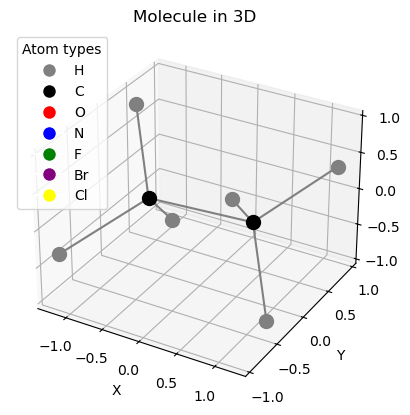

In [10]:
"Informations about the product that we want to form"

#name of the molecule

from chemspipy import ChemSpider

def get_molecule_name(smiles):
    """
    Get the common name of a molecule from its SMILES representation using ChemSpider.
    Args:
    - smiles (str): SMILES representation of the molecule.
    Returns:
    - name (str): Common name of the molecule.
    """
    cs = ChemSpider('your_api_key_here')  # Replace 'your_api_key_here' with your ChemSpider API key
    results = cs.simple_search(smiles)
    if results:
        return results[0].common_name
    else:
        return "Unable to retrieve molecule name."

print (get_molecule_name(string_input_mol))

#3D representation of the molecule



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def plot_molecule_3D(smiles):
    """
    Plot a molecule in 3D with different colors for different types of atoms and bonds between atoms.
    Args:
    - smiles (str): SMILES representation of the molecule.
    """
    # Generate RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print("Error: Unable to generate molecule from SMILES.")
        return
    
    # Add explicit hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Extract atom coordinates and symbols
    coords = mol.GetConformer().GetPositions()
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define colors for different atom types
    atom_colors = {'H': 'gray', 'C': 'black', 'O': 'red', 'N': 'blue', 'F': 'green', 'Br': 'purple', 'Cl': 'yellow'}

    # Plot atoms with different colors
    for atom_idx, symbol in enumerate(symbols):
        x, y, z = coords[atom_idx]
        color = atom_colors.get(symbol, 'brown')  # Default to brown for unknown atoms
        ax.scatter(x, y, z, c=color, label=symbol, s=100)

    # Helper function to plot bonds
    def plot_bond(ax, start_pos, end_pos, offset=np.array([0, 0, 0])):
        ax.plot([start_pos[0] + offset[0], end_pos[0] + offset[0]], 
                [start_pos[1] + offset[1], end_pos[1] + offset[1]], 
                [start_pos[2] + offset[2], end_pos[2] + offset[2]], c='gray')

    # Plot bonds between atoms with different styles for single and double bonds
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        start_pos = coords[start_idx]
        end_pos = coords[end_idx]
        bond_type = bond.GetBondType()
        
        if bond_type == Chem.rdchem.BondType.SINGLE:
            plot_bond(ax, start_pos, end_pos)
        elif bond_type == Chem.rdchem.BondType.DOUBLE:
            # Calculate an offset direction perpendicular to the bond
            bond_vector = end_pos - start_pos
            normal_vector = np.cross(bond_vector, np.array([1, 0, 0]))
            if np.linalg.norm(normal_vector) < 1e-3:
                normal_vector = np.cross(bond_vector, np.array([0, 1, 0]))
            normal_vector /= np.linalg.norm(normal_vector)  # Normalize the vector
            offset = normal_vector * 0.125
            plot_bond(ax, start_pos, end_pos, offset)
            plot_bond(ax, start_pos, end_pos, -offset)

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Molecule in 3D')

    # Show legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color, label=symbol)
               for symbol, color in atom_colors.items()]
    ax.legend(handles=handles, title='Atom types', loc='best')

    # Show plot
    plt.show()

plot_molecule_3D(string_input_mol)
